In [45]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from pickle import dump, load
import os
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from skimage.io import imread, imshow
from skimage.transform import resize

In [72]:
# load data
with open('data/all_trajs_zeroed.p', 'r') as f:
    all_trajs_zeroed = load(f)
    
with open('data/all_trajs_raw.p', 'r') as f:
    all_trajs_raw = load(f)

with open('data/train_test_ids.p', 'r') as f:
    train_test_ids = load(f)
    
with open('data/use_sets.p', 'r') as f:
    use_sets = load(f)

In [73]:
# processing data into autoregression chunks
train_trajs = np.take(all_trajs_zeroed[7], train_test_ids[7]['train'], axis=0)    
test_trajs = np.take(all_trajs_zeroed[7], train_test_ids[7]['test'], axis=0)

In [74]:
train_set, test_set = use_sets['train'], use_sets['test']
print(len(train_set))

365


In [75]:
train_trajs = np.take(train_trajs, list(train_set), axis=0)
test_trajs = np.take(test_trajs, list(test_set), axis=0)

(743,)
(365,)


In [76]:
T_i = 5
T_o = 5
subsample = 3
X_tr, Y_tr, X_t, Y_t = [], [], [], []

In [77]:
for train_traj in train_trajs:
    for k in range(subsample):
        inds = np.arange(k, len(train_traj), subsample)
        for i in range(len(inds) - T_i - T_o):
            X_tr.append(np.take(train_traj, inds[i:i+T_i], axis=0).flatten())
            Y_tr.append(np.take(train_traj, inds[i+T_i:i+T_i+T_o], axis=0).flatten())
X_tr = np.array(X_tr)
Y_tr = np.array(Y_tr)

In [78]:
for test_traj in test_trajs:
    for k in range(subsample):
        inds = np.arange(k, len(test_traj), subsample)
        for i in range(len(inds) - T_i - T_o):
            X_t.append(np.take(test_traj, inds[i:i+T_i], axis=0).flatten())
            Y_t.append(np.take(test_traj, inds[i+T_i:i+T_i+T_o], axis=0).flatten())
X_t = np.array(X_t)
Y_t = np.array(Y_t)

print(X_t.shape)
print(Y_t.shape)

(11196, 10)
(11196, 10)


In [79]:
X_tr = X_tr.reshape(X_tr.shape[0], 5, 2)
Y_tr = Y_tr.reshape(Y_tr.shape[0], 10)

X_t = X_t.reshape(X_t.shape[0], 5, 2)
Y_t = Y_t.reshape(Y_t.shape[0], 10)

print(X_t.shape)
print(Y_t.shape)

(11196, 5, 2)
(11196, 10)


### 5: LSTM

In [80]:
model = Sequential()
model.add(LSTM(128, input_shape=(5, 2)))
model.add(Dense(10))
from keras.utils.layer_utils import print_summary; print_summary(model)
model.compile(loss='mean_squared_error', optimizer='sgd')

model.fit(X_tr, Y_tr, epochs=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 128)               67072     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 68,362
Trainable params: 68,362
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5

41539/41539 [==============================] - 10s 234us/step - loss: 9821.6297
Epoch 2/5

41539/41539 [==============================] - 8s 196us/step - loss: 8653.8514
Epoch 3/5

41539/41539 [==============================] - 8s 197us/step - loss: 8635.9436
Epoch 4/5

41539/41539 [==============================] - 8s 197us/step - loss: 8630.9091
Epoch 5/5

41539/41539 [==============================] - 8s 203us/step - loss: 8732.1024


In [91]:
def gen_traj(model, init, T_i, T_o, T):
    traj = init.reshape(T_i, 2).tolist()    
    for i in range(T):
        seg = model.predict([np.array(traj[i:i+T_o]).flatten().reshape(1, 5, 2)])
        print(seg)
        x = seg.reshape(T_i, 2).tolist()[0]
        traj.append(x)
    return traj

In [95]:
class Dummy(object):
    def predict(self, arr):
        return arr[0] + 1

In [98]:
traj_pred_zero = gen_traj(model, X_t[0], T_i, T_o, 150)

[[  31.98616791 -153.30030823   33.05611038 -159.62173462   33.66527176
  -165.0276947    35.89622498 -171.40130615   35.6824646  -176.90779114]]
[[  29.06119156 -206.32398987   28.41147995 -212.97164917   28.33310318
  -220.02601624   28.70729828 -227.49482727   27.84422684 -235.06393433]]
[[  26.6851387  -203.35914612   25.971138   -209.92185974   25.85964012
  -216.91346741   26.02655411 -224.228302     25.26844025 -231.81924438]]
[[  21.94420624 -220.60191345   21.05768585 -227.62840271   20.85412788
  -235.01737976   20.74781418 -242.63595581   19.92458916 -250.46536255]]
[[  18.47378159 -229.66720581   17.68410492 -237.18469238   17.35347176
  -244.60639954   17.25945282 -252.43249512   16.40955353 -260.35772705]]
[[  29.63286591 -200.06344604   29.36183739 -206.49136353   29.06360054
  -212.43605042   29.15619659 -219.10525513   28.56344986 -225.85705566]]
[[  12.72578621 -227.76295471   11.84572506 -235.18379211   11.40765953
  -242.33790588   11.3517971  -250.0430603    10.453

In [87]:
def unzero_traj(traj, i, class_id, is_train=True):
    # find original id from train_test_ids
    id = train_test_ids[class_id]['train'][i] if is_train else train_test_ids[class_id]['test'][i]

    # get the first value from raw traj
    zero = all_trajs_raw[class_id][id][0]

    # reconstruct new raw traj
    unzeroed_traj = traj + zero
    
    return unzeroed_traj

In [88]:
street_raw = imread('/nfs/diskstation/jren/projection_average.png')
street = street_raw[97:719, 510:1132][:,:,:3]
street = resize(street, [1000,1000])

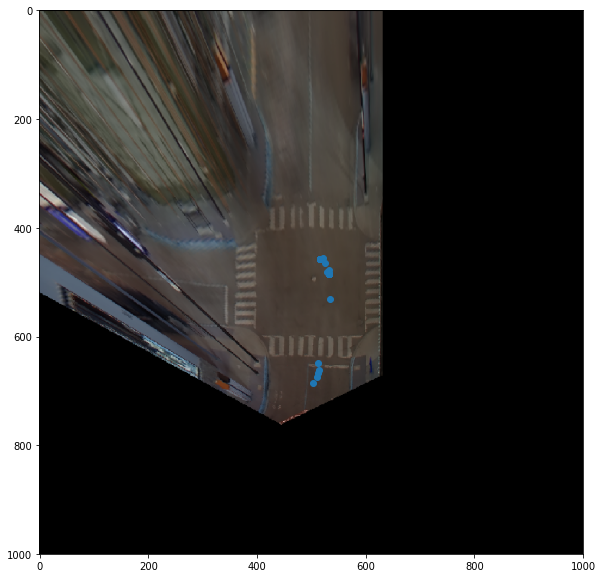

In [99]:
traj_pred = unzero_traj(traj_pred_zero, 0, 7, True)
plt.figure(figsize=(10,10))
plt.imshow(street)
plt.scatter(traj_pred[:,0], traj_pred[:,1])
plt.show()

In [90]:
print(traj_pred)

[[ 505.29901515  806.45429003]
 [ 504.91038199  803.57837466]
 [ 504.08709739  799.1583139 ]
 [ 503.94756558  798.66521958]
 [ 504.30342145  801.28396643]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.80436718  866.11396379]
 [ 494.8